# Dots and Boxes

*Jeffrey Buehler & Bobby Signor*
$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

## Background

Our goal for this project was to create an AI capable of beating a random opponent at a game called Dots and Boxes at least 80% of the time, using reinforcement learning techniques.

### The Game

Dots and Boxes is a simple game for two players. The gameboard consists of a grid of an abitrary size. For this project, we chose to fix the size of the board to 5 x 5 boxes.
<figure>
    <img src="img/0-empty.png">
    <figcaption>
        <div style="text-align: center">**Fig. 1.1:** An empty 5 x 5 board.</div>
    </figcaption>
</figure>

Each player switches off taking turns. A turn starts with the player drawing a line between two adjacent unconnected dots. If the new line the player draws does not complete a 1 x 1 square, then that player's turn is over and it is the other player's turn.
<figure>
    <img src="img/fig2.png">
    <figcaption>
        <div style="text-align: center">**Fig. 1.2:** An example of a player taking a turn and not completing a box.</div>
    </figcaption>
</figure>

However, if the player draws a line that does complete a 1 x 1 square, the player is rewarded a point for that box and gets to draw another line, with the above rule still in place.
<figure>
    <img src="img/fig3.png">
    <figcaption>
        <div style="text-align: center">**Fig. 1.3:** An example of a player drawing a line, completing a box, and then drawing another line.</div>
    </figcaption>
</figure>

The game ends when it is no longer possible to draw another line. The winner is determined by whoever has the most boxes at the end of the game. In the example game shown in Figure 1.4, player X would be the winner.
<figure>
    <img src="img/fig4.png">
    <figcaption>
        <div style="text-align: center">**Fig. 1.4:** An example of a board after a game's been completed. Here, player X has 16 points, while player O has 9.</div>
    </figcaption>
</figure>

#### A Simple Strategy

While the objective of the game is to score more points than your opponent, it is not always wise to complete boxes as quickly as possible. One strategy that is quickly learned by human opponents is creating paths that can eventually be completed without giving your opponent a chance to counter, as shown in Figure 1.3. When used correctly, this strategy maximizes the number of points earned by reducing the number of opportunities your opponent has to draw lines. However, this must be done with care, since your opponent may also take the opportunity to complete your path and steal those points from you.
<figure>
    <img src="img/fig5.png">
    <figcaption>
        <div style="text-align: center">**Fig. 1.5:** An example of a board setup that would net a single player 9 points before the other player can take their turn.</div>
    </figcaption>
</figure>

## Implementation

### Game

The Game object contains the complete state of the game and the logic required to correctly play it. Initializing it and starting a new game is as follows:

```python
g = Game()
g.play(player1, player2)
``` 

### Players

We have created 2 different kinds of players for our game:

1. **Random Player:** This player chooses moves simply by randomly choosing any of the available moves at random each time it's asked. Its play does not improve as it plays more games.
 
2. **AI Player:** This player uses reinforcement learning techniques (see below) to learn which move given a board state is most likely to result in a win, and choosing that one. We can also have it make some of its moves randomly for training by specifying the probability it takes a random move in a parameter called epsilon. While training, we start epsilon at 1 and steadily decay that number as the AI Player is exposed to more board states and more games.

## The Machine Learning Method: Reinforcement Programming

### Reinforcement Learning

Reinforcement learning is a method of machine learning used to teach a program to give correct output given input using reward/punishment. The behavior of a reinforced program is based on the psychological response of humans trying to suceed at a task. One way to picture this is to imagine a child being taught how to read by a grade-school teacher. They are presented with simple words and are asked to sound out the word. If presented incorrectly, the teacher will inform the child they were wrong and give feedback on how to improve. If the child pronounces the word correctly, they are given positive feedback, and sometimes some sort of reward. Eventually, the child will learn that certain letters interact with others in certian ways because they were given positive reinforcement when they did something correct.

### Applied to AI Player

We will be applying reinforcement learning to our AI Player. It will be reinforced depending on the moves it makes that end up winning a game. Positive reinforcement will be given whenever the AI is able to win a game. The decisions the AI makes will be determined on past experience of winning moves.

### Hypothesis

We believe if we train the AI enough, it will be able to defeat a random opponent easily. If we train it against another AI, it will be able to learn more sensible moves to make. We also believe that if trained against a human opponent, it will eventually learn the strategies talked about earlier that humans are able to do.

## Required Code

In [1]:
# External Game & Player Code
import game
import players

# Graphing
%pylab inline
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import IPython.display as ipd

# Misc.
import time

Populating the interactive namespace from numpy and matplotlib


## Training/Testing Functions

In [7]:
def playTestvsRandom(p1, p2, printturns = False):
    start = time.time()
    aiWins = 0
    winPercent = {}
    for i in range(trainIterations):
        g = game.Game()
        if i % 2 is 0:
            g.play(p1, p2, printturns=printturns)
        else:
            g.play(p2, p1, printturns=printturns)
        if g.score.index(max(g.score)) is p1.playernum:
            aiWins += 1
        winPercent[i] = aiWins / (i + 1)
    print("Train vs. Random:\t{} wins out of {}".format(aiWins, trainIterations))
    print("Took ", time.time() - start, "seconds.\n")
    return winPercent

def playTrainvsRandom(p1, p2, printturns = False):
    start = time.time()
    aiWins = 0
    winPercent = {}
    p1.train = False
    for i in range(randTestIterations):
        g = game.Game()
        if i % 2 is 0:
            g.play(p1, p2, printturns=printturns)
        else:
            g.play(p2, p1, printturns=printturns)
        if g.score.index(max(g.score)) is p1.playernum:
            aiWins += 1
        winPercent[i] = aiWins / (i + 1)
    print("Test vs. Random:\t{} wins out of {}".format(aiWins, randTestIterations))
    print("Took ", time.time() - start, "seconds.\n")
    return winPercent

def playTrainvsSelf(p1, p2, printturns = False):
    start = time.time()
    wins = [0, 0]
    p1.train = True
    p1.epsilon = initialEpsilon
    p2 = players.AIPlayer(rho=rho, epsilon=initialEpsilon, seed=seed2)
    p2.Q = p1.Q
    winPercent = {}
    aiWins = 0
    for i in range(aiTrainIterations):
        g = game.Game()
        g.play(p1, p2, printturns=False)
        wins[g.score.index(max(g.score))] += 1
        p1.epsilon *= epsilonDecay
        p2.epsilon *= epsilonDecay
        aiWins += 1
        winPercent[i] = aiWins / (i + 1)
    print("Train vs. Self:\t{} wins to {} wins".format(wins[0], wins[1]))
    print("Took ", time.time() - start, "seconds.\n")
    return winPercent

def playTestvsSelf(p1, p2, printturns = False):
    start = time.time()
    wins = [0, 0]
    p1.train = False
    p2.train = False
    aiWins = 0
    winPercent = {}
    for i in range(aiTestIterations):
        g = game.Game()
        g.play(p1, p2, printturns=False)
        wins[g.score.index(max(g.score))] += 1
        aiWins += 1
        winPercent[i] = aiWins / (i + 1)
    print("Test vs. Self:\t{} wins to {} wins".format(wins[0], wins[1]))
    print("Took ", time.time() - start, "seconds.\n")
    return winPercent

In [3]:
def play(p1, p2, printturns = False):
    winPercentage1 = playTestvsRandom(p1, p2, printturns)
    winPercentage2 = playTrainvsRandom(p1, p2, printturns)

    print("--------------------------------------------")

    winPercentage3 = playTrainvsSelf(p1, p2, printturns)
    winPercentage4 = playTestvsSelf(p1, p2, printturns)
    return winPercentage1, winPercentage2, winPercentage3, winPercentage4

## Graphing Functions

In [4]:
def graph_all(board):
    graph_board(board)

def graph_epsilon():
    return 0

def graph_board(board):
    plt.plot(board.shape[1] - 1, board.shape[1] - 1)
    plt.xlim(-1,board.shape[1])
    plt.ylim(-1,board.shape[1])
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    
    for r in range(board.shape[0]):
        for c in range(board.shape[1]):
            x = None
            if board[r, c] == True:
                if r % 2 == 0:
                    if c < 5:
                        x, y = [c, c + 1], [int(r / 2), int(r / 2)]
                else:
                    x, y = [c, c], [int(r / 2), int(r / 2) + 1]
                if x is not None:
                    plt.plot(x, y, color="#000000")
    
    for i in range(board.shape[1]):
        for j in range(board.shape[1]):
            plt.scatter(i, j)

def graph_win_percentage(winPercent, graphTitle="Games Won by Percentage"):
    pointsToPlotPercent = .01
    frames = int(len(winPercent) * pointsToPlotPercent)
    for key, value in winPercent.items():
        if (key % frames == 0):
            plt.scatter(key, value, marker='.')
    plt.xlim(0, len(winPercent))
    plt.ylim(0, 1)
    x, y = [0, len(winPercent)], [.5, .5]
    plt.plot(x, y, color="r")
    xlabel('Games')
    ylabel('Win (%)')
    title(graphTitle)
    print("Final Percent Win: ", winPercent[len(winPercent) - 1])

## Control

These parameters will represent our control data. We are playing one Random Player against another Random Player to determine if there is little variance in two palyers chosing random moves.

In [5]:
trainIterations = 20000
randTestIterations = 2000
rho = 0.2
initialEpsilon = 1.0
epsilonDecay = 0.99
seed1 = None
seed2 = None

# Random vs. Random (Control)

Random vs. Random: 987 wins to 1013 wins (2000 games total).
Took 5.18863320350647 seconds.
Final Percent Win:  0.4935


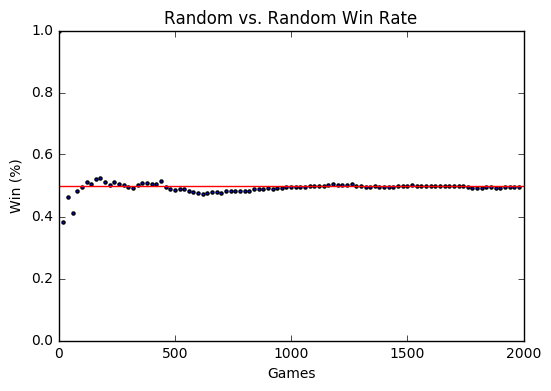

In [18]:
# Random vs. Random
chaosIterations = 2000
start = time.time()
wins = [0, 0]
winRecordTracker = {}
p1 = players.RandomPlayer()
p2 = players.RandomPlayer()

for i in range(chaosIterations):
    g = game.Game()
    g.play(p1, p2)
    wins[g.score.index(max(g.score))] += 1
    winRecordTracker[i] = wins[0] / (i + 1)

print("Random vs. Random: {} wins to {} wins ({} games total).".format(wins[0], wins[1], chaosIterations))
print("Took", time.time() - start, "seconds.")
graph_win_percentage(winRecordTracker, "Random vs. Random Win Rate")

#### Observations
We can see that win percentages keep roughly around 50%, which was expected when two players simply choosing random moves go against each other.

An intersting observation that we saw was when training the data against another Random player, wins started slowly decreasing. After increasing the number of iterations 10-fold, we noticed that that discrimination went away, leading to ~50% win/loss ratio.

These are expected and show that there is no significant discrimination between which player goes first and winning the game.

## Experiment 1

Here is the first instance of testing our AI based on Reinforcement Learning versus our Random Player.

In [ ]:
trainIterations = 2000
randTestIterations = 200
aiTrainIterations = 2000
aiTestIterations = 200
rho = 0.2
initialEpsilon = 1.0
epsilonDecay = 0.99
seed1 = None
seed2 = None

p1 = players.AIPlayer(rho=rho, epsilon=initialEpsilon, seed=seed1)
p2 = players.RandomPlayer(seed=None)

In [ ]:
winPercent1, winPercent2, winPercent3, winPercent4 = play(p1, p2)

In [ ]:
graph_win_percentage(winPercent1, "Train vs. Random Wins")

In [ ]:
graph_win_percentage(winPercent2, "Test vs. Random Wins")

In [ ]:
graph_win_percentage(winPercent3, "Train vs. Self Wins")

In [ ]:
graph_win_percentage(winPercent4, "Test vs. Self Wins")

#### Obserations
The data clearly shows that using reinforcement versus a random player will result in consistent wins. 

## Experiment 2

We decided to increase the number of games played between the AI and the Random Player, and the AI against another AI. Iteration counts were multiplied by 10 compared to our control to see how quickly our AI could learn.

In [ ]:
trainIterations = 20000
randTestIterations = 2000
aiTrainIterations = 20000
aiTestIterations = 2000
rho = 0.2
initialEpsilon = 1.0
epsilonDecay = 0.99
seed1 = None
seed2 = None

p1 = players.AIPlayer(rho=rho, epsilon=initialEpsilon, seed=seed1)
p2 = players.RandomPlayer(seed=None)

In [ ]:
winPercent1, winPercent2, winPercent3, winPercent4 = play(p1, p2)

In [ ]:
graph_win_percentage(winPercent1, "Train vs. Random Wins")

In [ ]:
graph_win_percentage(winPercent2, "Test vs. Random Wins")

In [ ]:
graph_win_percentage(winPercent3, "Train vs. Self Wins")

In [ ]:
graph_win_percentage(winPercent4, "Test vs. Self Wins")

#### Observations
We noticed ...

# Experiment 3

We wanted to see what would happen if we put an AI Reinforced player up against another AI Reinforced player.

In [ ]:
trainIterations = 2000
randTestIterations = 200
aiTrainIterations = 2000
aiTestIterations = 200
rho = 0.2
initialEpsilon = 1.0
epsilonDecay = 0.99
seed1 = None
seed2 = None

p1 = players.AIPlayer(rho=rho, epsilon=initialEpsilon, seed=seed1)
p2 = players.AIPlayer(rho=rho, epsilon=initialEpsilon, seed=seed2)

In [ ]:
winPercent1, winPercent2, winPercent3, winPercent4 = play(p1, p2)

In [ ]:
graph_win_percentage(winPercent1, "Train vs. Random Wins")

In [ ]:
graph_win_percentage(winPercent2, "Test vs. Random Wins")

In [ ]:
graph_win_percentage(winPercent3, "Train vs. Self Wins")

In [ ]:
graph_win_percentage(winPercent4, "Test vs. Self Wins")

#### Observations
We noticed...

# Experiment 4

This is what we are doing...

In [ ]:
trainIterations = 2000
randTestIterations = 200
aiTrainIterations = 2000
aiTestIterations = 200
rho = 0.2
initialEpsilon = 1.0
epsilonDecay = 0.99
seed1 = None
seed2 = None

p1 = players.AIPlayer(rho=rho, epsilon=initialEpsilon, seed=seed1)
p2 = players.RandomPlayer(seed=None)

In [ ]:
winPercent1, winPercent2, winPercent3, winPercent4 = play(p1, p2)

In [ ]:
graph_win_percentage(winPercent1, "Train vs. Random Wins")

In [ ]:
graph_win_percentage(winPercent2, "Test vs. Random Wins")

In [ ]:
graph_win_percentage(winPercent3, "Train vs. Self Wins")

In [ ]:
graph_win_percentage(winPercent4, "Test vs. Self Wins")

#### Ovservations
We noticed...

# For Making Diagrams (REMOVE BEFORE SUBMISSION)

In [ ]:
b = game.Game.Board()

b[0, 0] = True

b[1, 0] = True
b[1, 1] = True

b[2, 0] = True

b[3, 0] = True
b[3, 1] = True

b[4, 0] = True

b[5, 0] = True
b[5, 1] = True

b[6, 0] = True
b[6, 1] = True
b[6, 2] = True

b[7, 0] = True
b[7, 1] = True
b[7, 2] = True
b[7, 3] = True

b[8, 0] = True
b[8, 1] = True
b[8, 2] = True

b[9, 0] = True
b[9, 1] = True
b[9, 2] = True
b[9, 3] = True

b[10, 0] = True
b[10, 1] = True
b[10, 2] = True

graph_board(b)

# Conclusion

The data shows ...